# Week 9 - Anomaly Detection

This week, we're covering anomaly detection and recommender systems. For a large dataset, we may need to identify which datapoints vary significantly from the average. This can be applied to, for example, detecting defects in a manufacturing facility. Recommender systems, used by companies like Netflix and Amazon, look for patterns of activities and use these patterns to produce a recommendation.

The topics we'll cover this week are:
* Anomaly Detections
  * Density Estimation
    * Motivation
    * Gaussian Distribution
    * Algorithm
  * Building an Anomaly Detection System
    * Developing and Evaluating an Anomaly Detection System
    * Anomaly Detection vs. Superverised Learning
    * Choosing What Features to Use
  * Multivariate Gaussian Distribution
    * Anomaly Detection with MVGD
* Recommender Systems
  * Predicting Movie Ratings
    * Problem Formulation
    * Content Based Recommendations
  * Collaborative Filtering
    * Collaborative Filtering Algorithm
  * Low Rank Matrix Factorization
    * Vectorization: Low Rank Matrix Factorization
    * Implementational Detail: Mean Normalization
  
## Anomaly Detections

### Density Estimation

#### Motivation

Imagine you're a manufacturer of aircraft engines, and as they roll off of the assembly line, you measure certain features of the engines, such as the heat generated, the intensity of their vibration, etc.. So we'll have a dataset 

$$ \{ x^{(1)}, x^{(2)}, \cdots , x^{(m)} \}.$$

So the next day, let's say we have a new test engine

$$ x_\text{test} $$

that we need to examine. We can compare the features of this new engine to the previous batch we had. If the feature values are comparable to the training set, then we're good to go, but if it lies substantially far away, we would say that it is an anomaly. 

So formally, we a dataset

$$ \{ x^{(1)}, x^{(2)}, \cdots , x^{(m)} \},$$

we want to know if

$$ x_\text{test} $$

is anomalous. We'll create a model

$$ p(x) $$

that describes the probability associated with these features. If 

$$ p(x_\text{test}) < \epsilon \Rightarrow \text{ flag anomaly } $$

This is similar to seeing where the new test samples lie in the density of the training set, since the more dense part of the training set in the feature space will be greatest near the highest part of our probability model.

#### Gaussian Distribution

If we have a Gaussian distribution with
* mean $\mu$
* variance $\sigma^2$, or standard deviation $\sigma$

we say

$$ x \sim \mathcal{N} (\mu,\sigma^2).$$

The distribution resembles a bell-shaped curved with one mode centered at the mean and spread controlled by the variance. The formula for the Gaussian distribution is

$$ p (x;\mu,\sigma^2) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \Big( - \frac{(x-\mu)^2}{2 \sigma^2} \Big) $$

The standard deviation has the property that, 60.7\% of the distrubition is contained within one standard deviation on either side of the mean. Therefore, decreasing the standard deviation decreases the spread of the distribution. 

Below are a few examples of different Gaussian distributions.

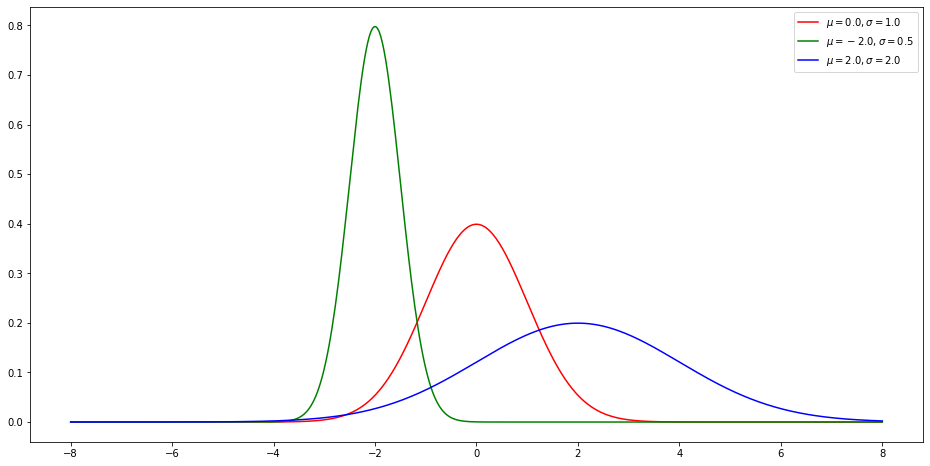

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

# Define Gaussian function
def gaussian(x,mu,sigma):
    return (1./(np.sqrt(2.*np.pi)*sigma))*np.exp(-((x-mu)**2)/(2.0*sigma**2))
    
# Set parameters
muList = [0.0,-2.0,2.0]
sigmaList = [1.0,0.5,2.0]

# Build x array and get Gaussian distributions
x = np.linspace(-8,8,501)
pList = [gaussian(x,muList[i],sigmaList[i]) for i in range(len(muList))]

# Plot functions
fig, ax = plt.subplots(figsize=(16,8));
colors = ["r","g","b"]
for i in range(len(muList)):
    ax.plot(x,pList[i],color=colors[i],label="$\mu = "+str(muList[i])+", \sigma = "+str(sigmaList[i])+"$");
ax.legend();

Now let's discuss the parameter estimation problem. Let's say we have a dataset that we suspect is Gaussian distributed. Initially, we don't know what the parameters (mean and standard deviation) of the distrubition are. We have formulas for these parameters:

$$ \begin{align}
\mu & = \frac{1}{m} \sum_{i=1}^{m} x^{(i)} \\
\sigma^2 & = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)} - \mu)^2 \\
\end{align} $$

So we can find these values from the data itself without needing to do any sore of parameter fitting or anything.

#### Algorithm

Now let's apply the Gaussian distribution to anomaly detection. Let's say we have a training set

$$ \{ x^{(1)}, x^{(2)}, \cdots , x^{(m)} \},$$

where each example is

$$ x \in \mathbb{R}^n.$$

Our probability for each sample will be a product of probabilities corresponding to each feature. We begin by assuming each feature has Gaussian distribution:

$$ x_i \sim \mathcal N (\mu_i,\sigma_i^2) .$$

Then our probability for a given sample is

$$ p (x) = p(x_1;\mu_1,\sigma_1^2) p(x_2;\mu_2,\sigma_2^2) \cdots p(x_n;\mu_n,\sigma_n^2) = \prod_{j=1}^n p(x_j;\mu_j,\sigma_j^2) $$

This is an *independent* assumption for each feature, but this isn't such a big deal. 


Our algorithm for anomaly detection then is as follows:
1. Choose features $x_i$ that you think might be indicative of anomalous examples.
2. Fit parameters $\mu_j$ and $\sigma_j$ with
   $$ \begin{align}
   \mu_j & = \frac{1}{m} \sum_{i=1}^{m} x_j^{(i)} \\
   \sigma_j^2 & = \frac{1}{m} \sum_{i=1}^{m} (x_j^{(i)} - \mu_j)^2 \\
   \end{align} $$
3. Given a new example $x$, compute $p(x)$
   $$ p(x) = \prod_{j=1}^n p(x_j;\mu_j,\sigma_j^2)  = \prod_{j=1}^n \frac{1}{\sqrt{2 \pi} \sigma_j} \exp \Big( - \frac{(x_j-\mu_j)^2}{2 \sigma_j^2} \Big) $$
4. Declare anomaly if $p(x) < \epsilon$

### Building an Anomaly Detection System

#### Developing and Evaluating an Anomaly Detection System

When developing a learning algorithm, it's easier to make decisions if we have some way to evaluate our learning algorithm. Assume we have some labeled data,
* $y=0$ if normal
* $y=1$ if anomalous

We'll have our training set as the unlabeled training sample. We assume this training set has all normal or non-anomalous data. We'll also have our cross validation set and test set with some samples that are *known* to be anomalous.

So for example, let's say we have 10,000 good/normal aircraft engines, and 20 that are flawed. We could then break our data sets into
* training set: 6,000 good engines
* cross-validation set:  2,000 good engines, 10 anomalous
* test set: 2,000 good engines, 10 anomalous

We'd use the training set to build the probability model. On the cross validation/test examples, predict

$$ y = \begin{cases} 1 & \text{ if } p(x) < \epsilon \text{ (anomaly)} \\ 0 & \text{ if } p(x) \geq \epsilon \text{ (normal)} \end{cases} $$

Note that the dataset classifications are very skewed, since there are many more normal than anomalous examples. At this point, some possible evaluation metrics are
* counts of true positives, false positives, false negatives, true negatives
* precision/recall
* F-score

We can also use the cross validation set to choose the probability threshold parameter.

#### Anomaly Detection vs. Supervised Learning 

We're using some labeled data here, so why not just use supervised learning algorithm? We'll discuss some of the reasons to use one or the other here.

Anomaly Detection | Supervised Learning
--- | ---
small (large) number of positive (negative) examples | large number of both positive and negative examples
many different types of anomalies such that it's hard for any algorithm to learn what a positive example looks like | there are enough positive examples for the algorithm to get a sense of what a typical positive example looks like

Some examples of the two use cases are:

Anomaly Detection | Supervised Learning
--- | ---
fraud detection | email spam classification
manufacturing | weather prediction
monitoring machines in a data center | cancer classification

#### Choosing What Features to Use

We modeled our probability model as a Gaussian. This will usually work alright even if the features aren't strictly Gaussian. But if the distribution is highly non-Gaussian, it's best to apply some transformations. For example, perhaps the data isn't Gaussian distributed, but the logarithm transformation *is* more Gaussian distribution. We can raise the data to various powers to make it more Gaussian.

For error analysis, note that we want large probabilities for normal examples, and we want small probabilities for anomalous examples. The most common problem for feature selection is that the probability is comparable for normal *and* anomalous examples. It's a good practice to, if the algorithm fails, to look at cases that fail in order to determine a new feature to provide.

Let's look at an example of looking at computers in a data center. We can look at some features
* $x_1$: memory use of a computer
* $x_2$: number of disk accesses/second
* $x_3$: CPU load
* $x_4$: network traffic

We may find a failure case is where a computer gets stuck in an infinite loop, so the CPU load grows while the network traffic does not. So to test that case, we could create a new feature that is

$$ x_5 = \frac{\text{CPU load}}{\text{network traffic}} $$

that would grow unusually large for this particular case.

### Multivariate Gaussian Distribution

Say we have two features, for example, CPU load and memory use. These two features are more than likely going to be positively correlated, so it's not always best to model the two features separately. So instead of modeling the probabilities of each feature separately, we can create a single probability model with the multivariate Gaussian distribution. Our parameters are 

$$ \mu \in \mathbb{R}^n, \Sigma \in \mathbb{R}^{n \times n} $$

and our probability model is 

$$ p(x;\mu,\Sigma) = \frac{1}{(2 \pi)^\frac{n}{2} \det(\Sigma)^\frac{1}{2}} \exp \Big(- \frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu)\Big).$$

#### Some Examples

Let's now look at the following examples using code. We'll first create some functions to plot the data.

In [2]:
# Import modules
from mpl_toolkits import mplot3d

# Create probability function
def mvgd(X,mu,Sigma):
    """Produce the multivariate Gaussian distribution for given means and covariance matrix"""
    
    # Get feature size
    n = mu.shape[0]

    # Compute the probability model
    X = X - mu
    p = (2 * np.pi)**(-n/2) * np.linalg.det(Sigma)**(-0.5)
    p = p*np.exp(-0.5*np.sum(np.dot(X,np.linalg.pinv(Sigma))*X,axis=1))
    return p

def visualize_mvgd(mu,Sigma,count):
    
    """Generate plots of MVGD examples"""

    # Build grid
    x1 = np.linspace(-4.0,4.0,801)
    x2 = np.linspace(-4.0,4.0,801)
    X = np.array([x1,x2]).T
    
    # Set up for 3D grid and get MVGD
    X1, X2 = np.meshgrid(x1,x2)
    Z = mvgd(np.stack([X1.ravel(), X2.ravel()], axis=1),mu,Sigma)
    Z = Z.reshape(X1.shape)
    
    # Create a plot of the new feature
    fig = plt.figure(figsize=(12,10));
    ax = fig.add_axes([0,0,1,1]);
    contour = ax.contourf(x1,x2.T,Z,cmap='viridis')
    ax.set_xlabel('$x_1$',fontsize=24);
    ax.set_ylabel('$x_2$',fontsize=24);
    ax.set_title('MVGD, Example '+str(count),fontsize=32);
    cbar = plt.colorbar(contour,ax=ax);

    # Create a 3D plot
    fig = plt.figure(figsize=(18,9))
    ax = plt.axes(projection='3d')
    ax.set_xlabel(r'$x_1$',fontsize=24);
    ax.set_ylabel(r'$x_2$',fontsize=24);
    ax.set_zlabel(r'$p$',fontsize=24);
    ax.set_title('MVGD, Example '+str(count),fontsize=32);
    surface = ax.plot_surface(X1,X2,Z,cmap='viridis');
    cbar = plt.colorbar(surface,ax=ax);

##### Example 1

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $$

Here we have a basic Gaussian distribution that is symmetrically distributed between the two features and centered at the origin.

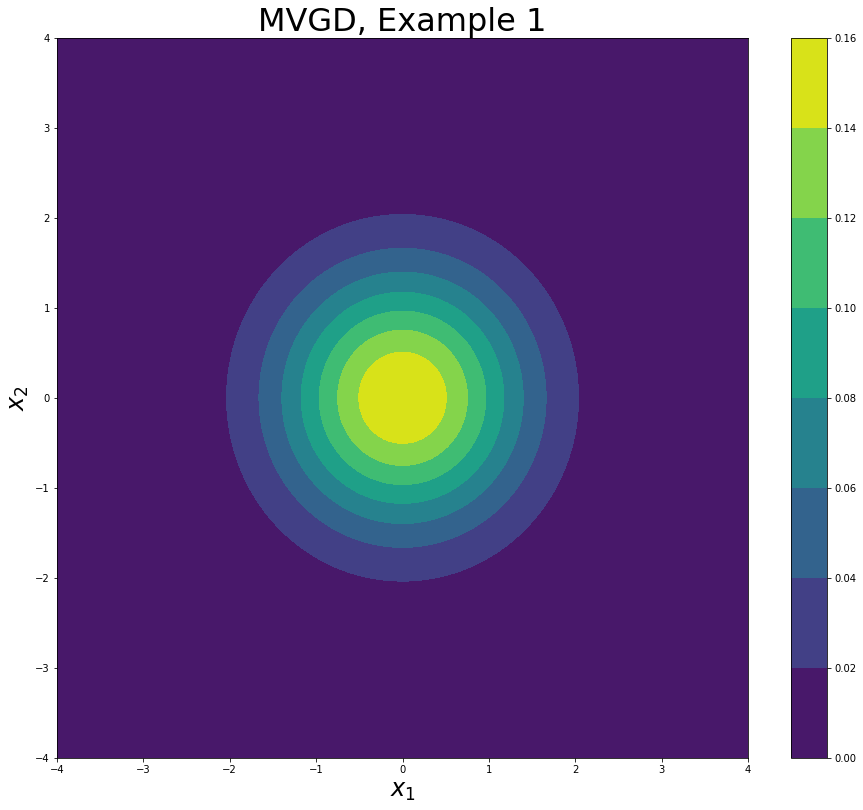

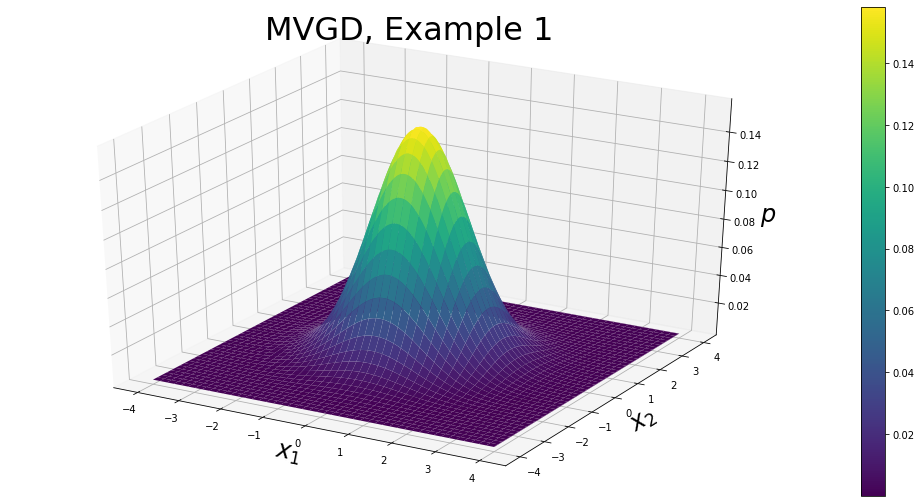

In [3]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[1,0],[0,1]])

# Generate plot
visualize_mvgd(mu,Sigma,1)

##### Example 2

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 0.6 & 0 \\ 0 & 0.6 \end{bmatrix} $$

We're still symmetrically distributed, but now our distribution is less spread.

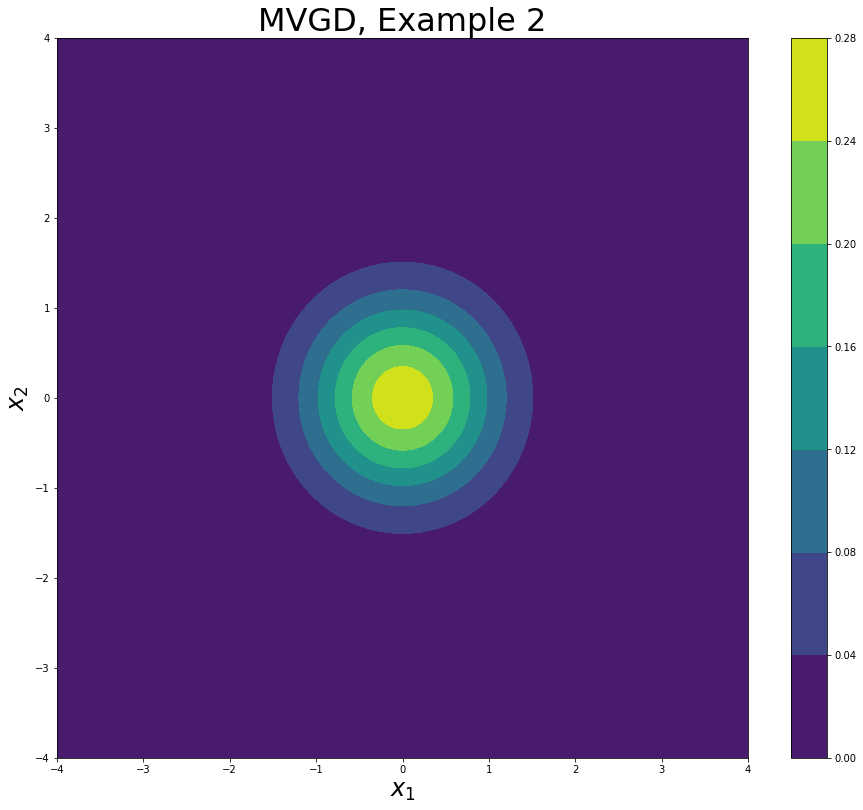

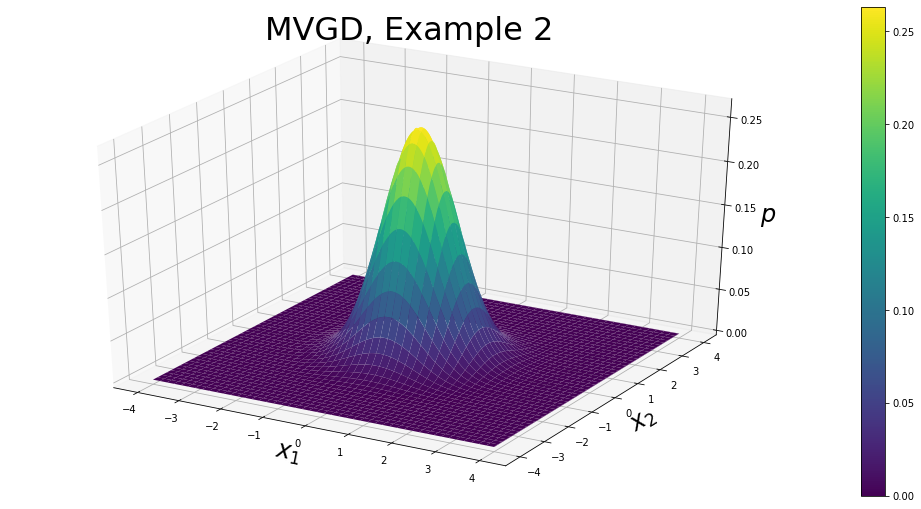

In [4]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[0.6,0],[0,0.6]])

# Generate plot
visualize_mvgd(mu,Sigma,2)

##### Example 3

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 2 & 0 \\ 0 & 2 \end{bmatrix} $$

We're still symmetrically distributed, but now our distribution is *more* spread.

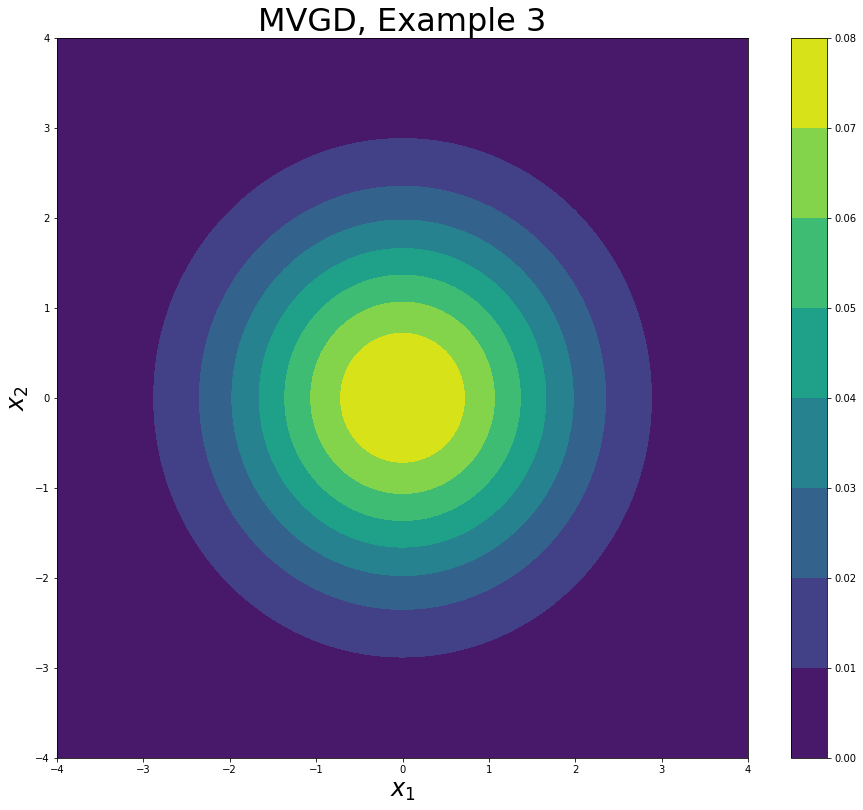

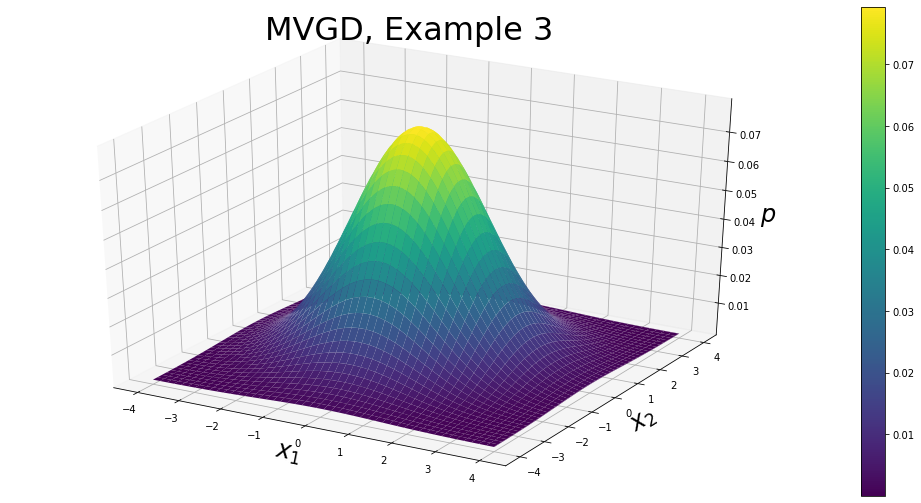

In [5]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[2,0],[0,2]])

# Generate plot
visualize_mvgd(mu,Sigma,3)

##### Example 4

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 0.6 & 0 \\ 0 & 1 \end{bmatrix} $$

In this example, we have more spread in the second feature than in the first.

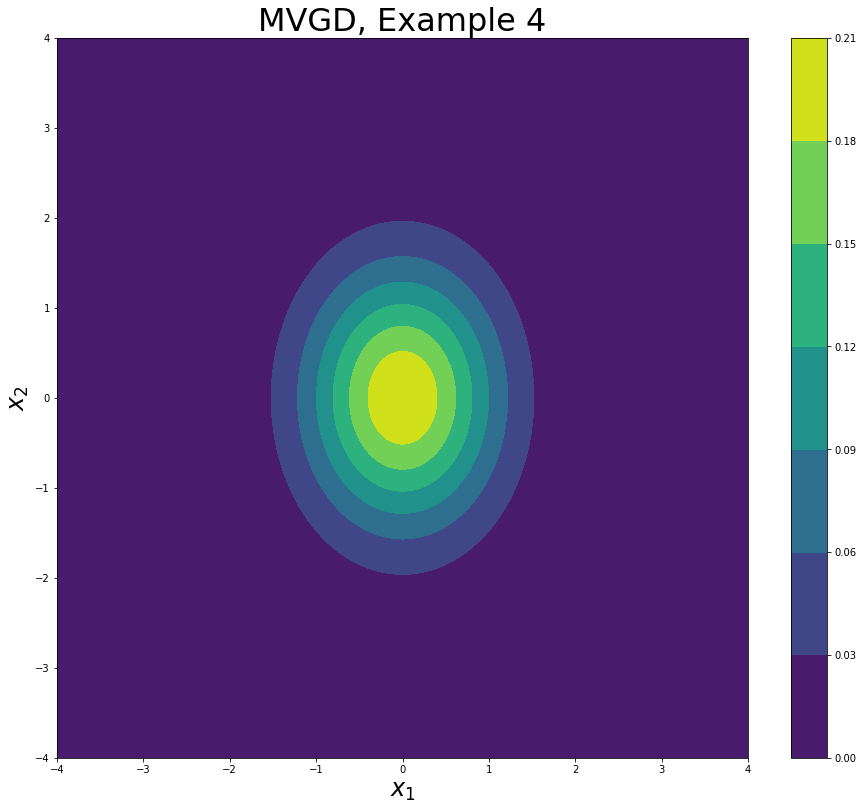

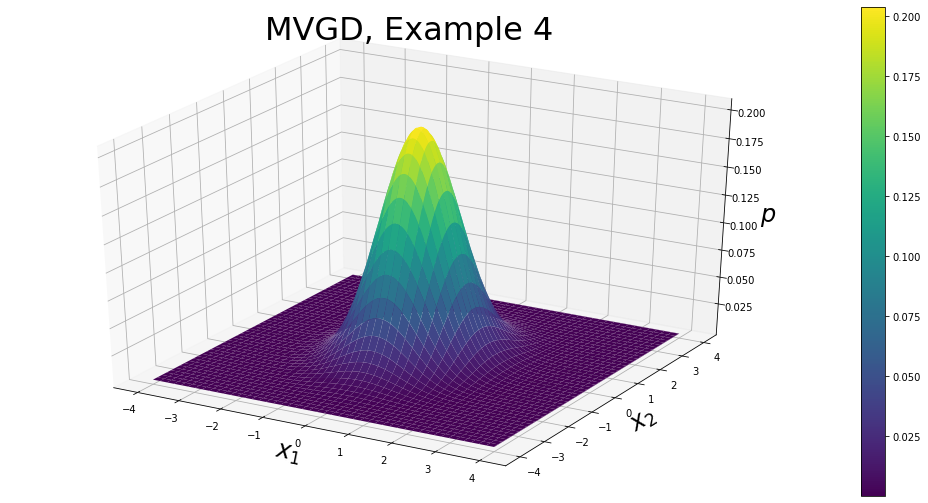

In [6]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[0.6,0],[0,1]])

# Generate plot
visualize_mvgd(mu,Sigma,4)

##### Example 5

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 2 & 0 \\ 0 & 1 \end{bmatrix} $$

Now, we're more spread about the second feature than the first.

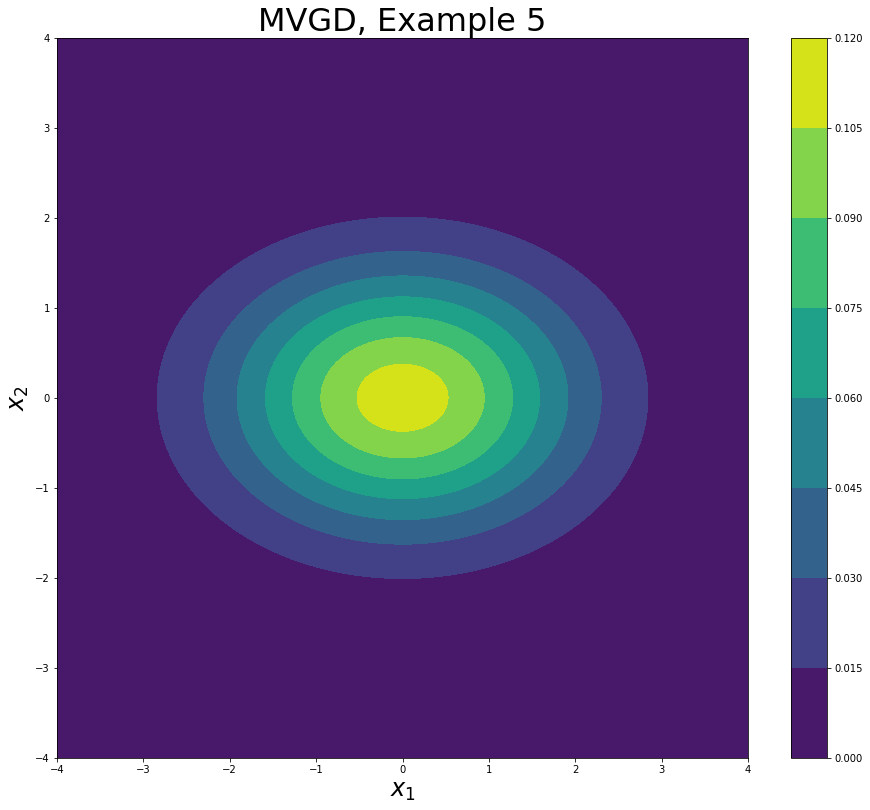

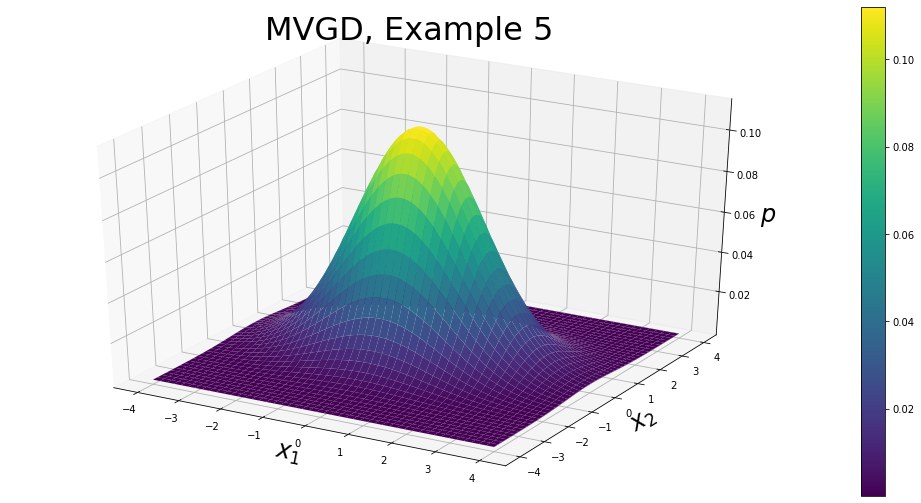

In [7]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[2,0],[0,1]])

# Generate plot
visualize_mvgd(mu,Sigma,5)

##### Example 6

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} $$

Now, we're equally spread, but we're exhibiting correlations between the two features.

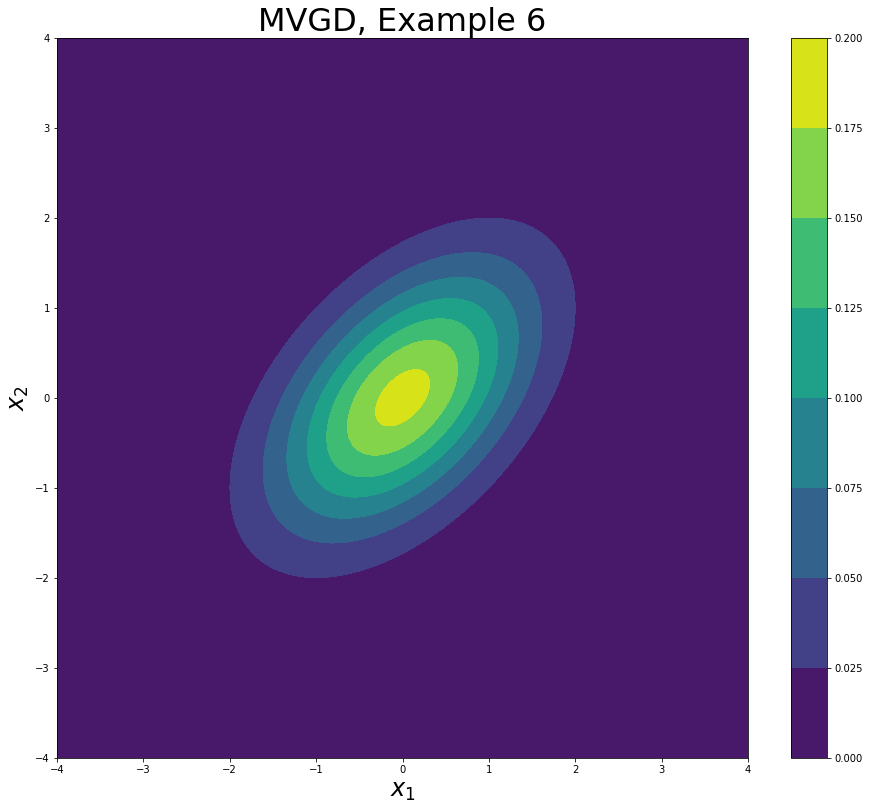

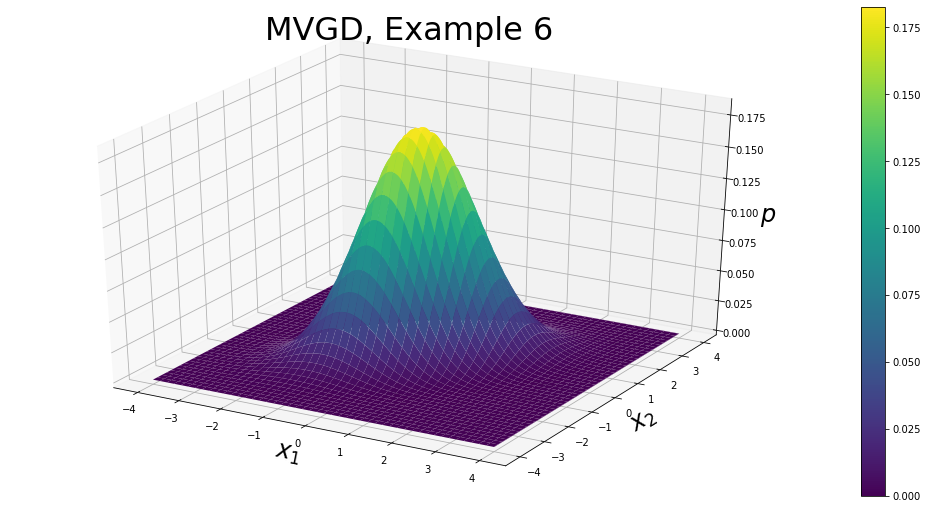

In [8]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[1,0.5],[0.5,1]])

# Generate plot
visualize_mvgd(mu,Sigma,6)

##### Example 7

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.8 \\ 0.8 & 1 \end{bmatrix} $$

As in Example 6, but we have even greater correlation between the two features.

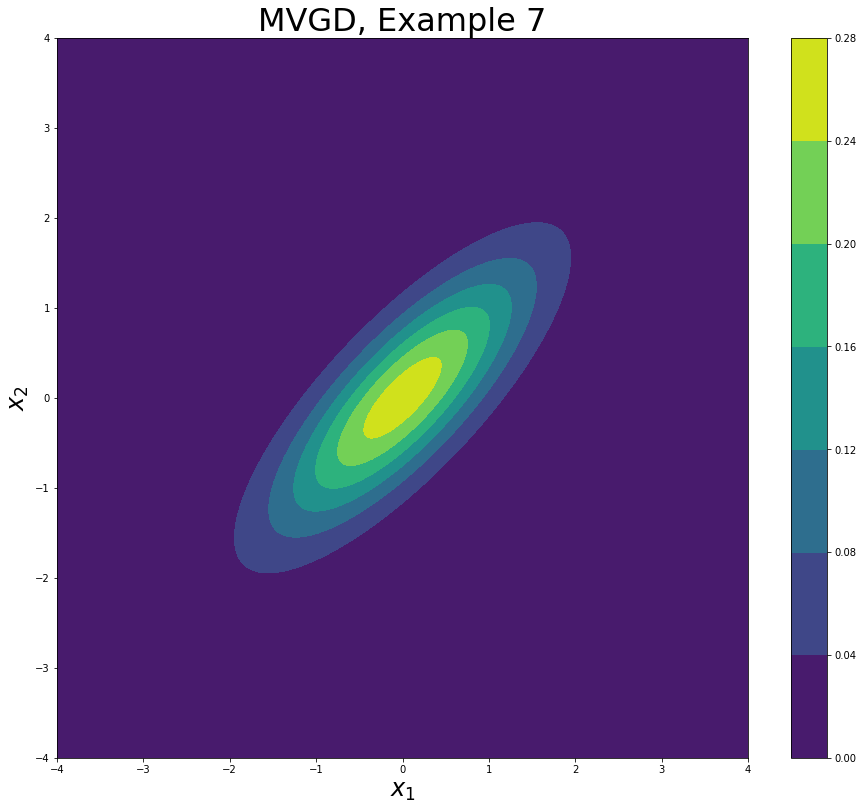

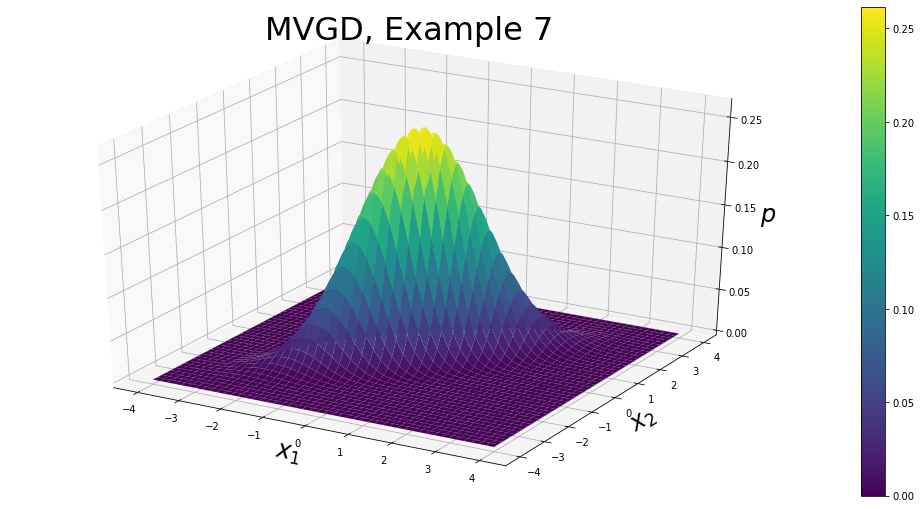

In [9]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[1,0.8],[0.8,1]])

# Generate plot
visualize_mvgd(mu,Sigma,7)

##### Example 8

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & -0.5 \\ -0.5 & 1 \end{bmatrix} $$

As in Example 6, but the correlations are opposite.

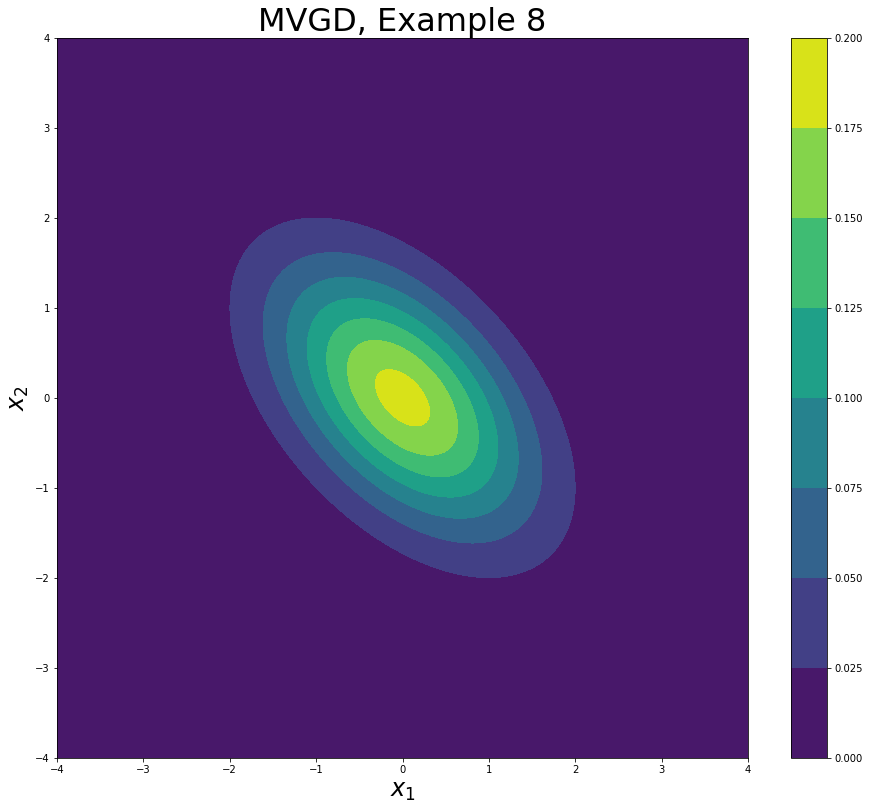

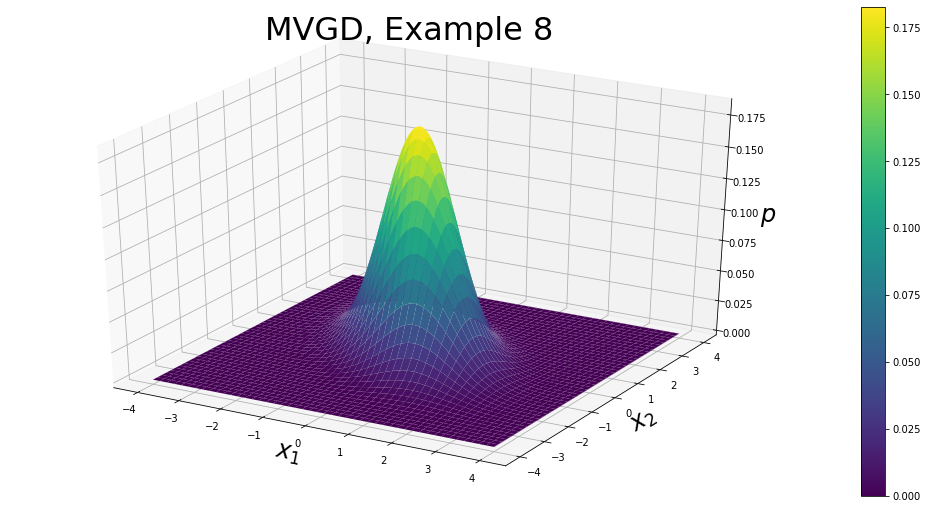

In [10]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[1,-0.5],[-0.5,1]])

# Generate plot
visualize_mvgd(mu,Sigma,8)

##### Example 9

$$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & -0.8 \\ -0.8 & 1 \end{bmatrix} $$

As in Example 8, but our correlations are again tighter.

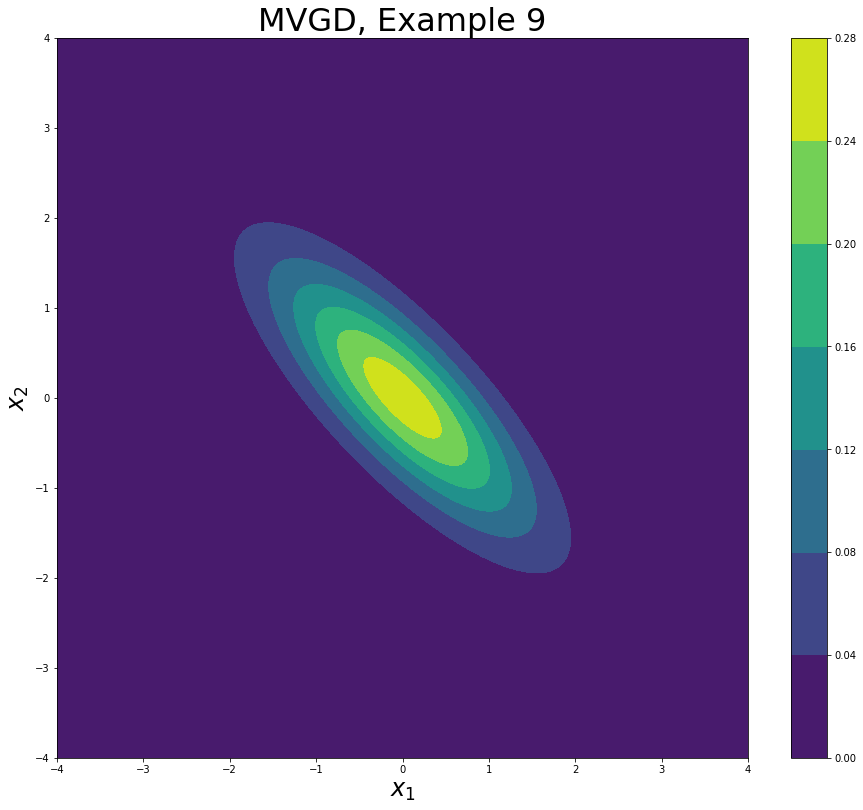

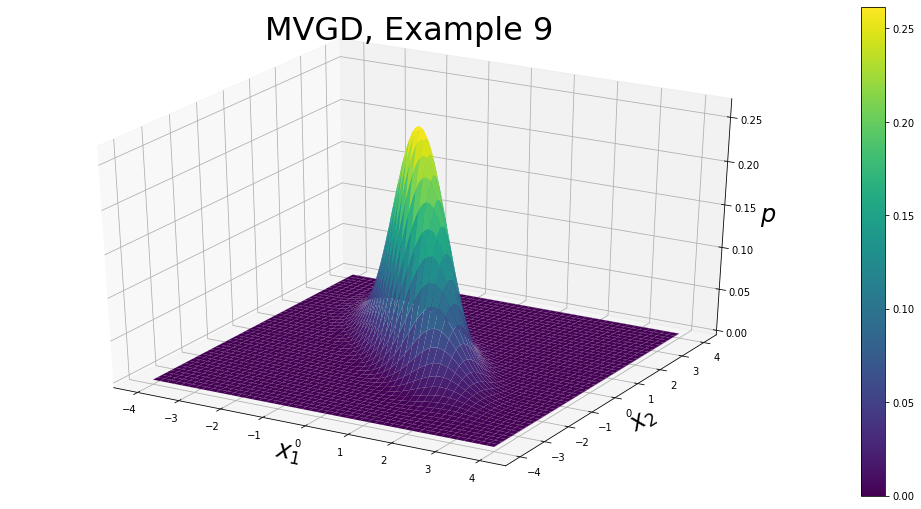

In [11]:
# Set parameters
mu = np.array([0,0])
Sigma = np.array([[1,-0.8],[-0.8,1]])

# Generate plot
visualize_mvgd(mu,Sigma,9)

We can also vary the means which would shift the center of the distribution to the value of the means. Let's look at two examples.

##### Example 10

$$ \mu = \begin{bmatrix} 0 \\ 0.5 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $$

This is the same as Example 1, but our center has shifted to (0,0.5) in the feature space.

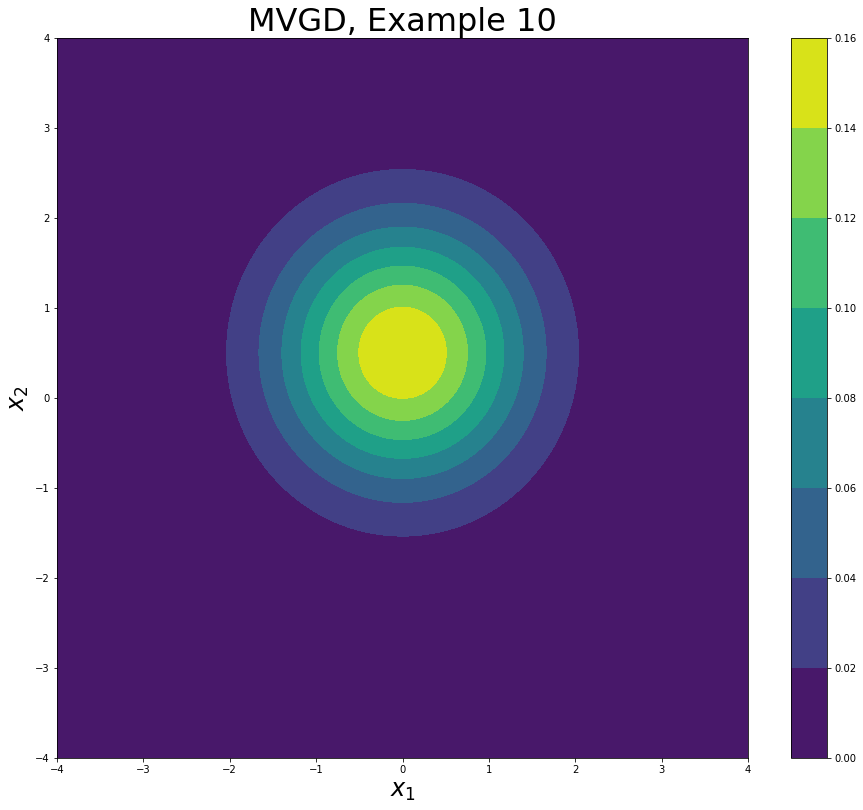

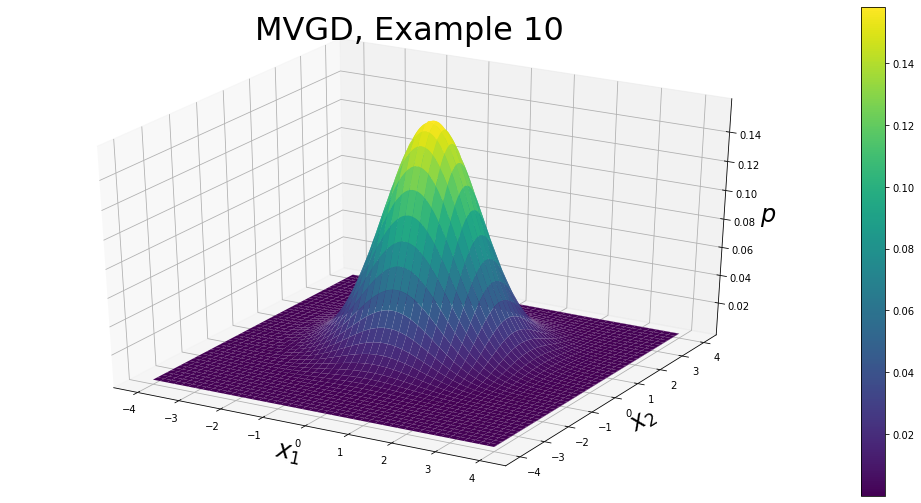

In [12]:
# Set parameters
mu = np.array([0,0.5])
Sigma = np.array([[1,0],[0,1]])

# Generate plot
visualize_mvgd(mu,Sigma,10)

##### Example 11

$$ \mu = \begin{bmatrix} 1.5 \\ -0.5 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $$

Now our center has shifted to (1.5,-0.5) in the feature space.

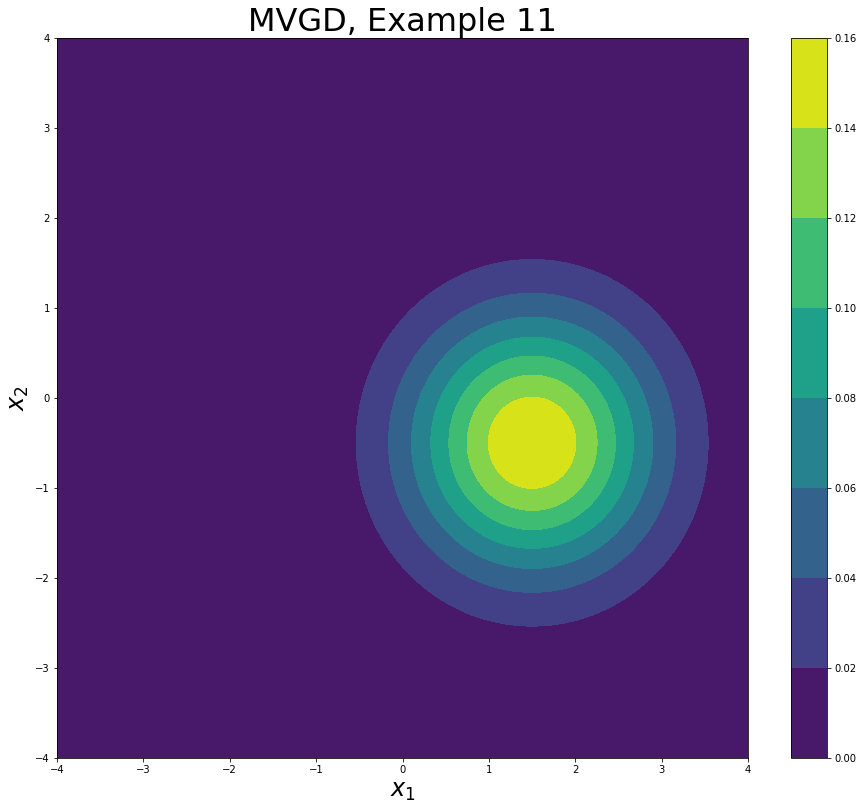

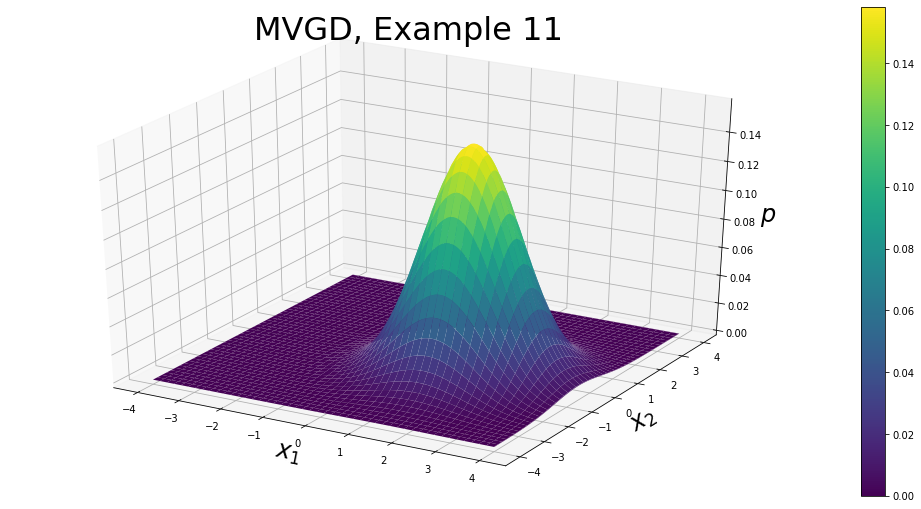

In [13]:
# Set parameters
mu = np.array([1.5,-0.5])
Sigma = np.array([[1,0],[0,1]])

# Generate plot
visualize_mvgd(mu,Sigma,11)

And of course, we can out these changes altogether so that we're varying the correlation, spread, and center of the distribution simultaneously.

#### Anomaly Detection using the Multivariate Gaussian Distribution

Again, we'll need to fit the parameters as such

$$ \mu = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}, \Sigma = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)} - \mu)((x^{(i)} - \mu)^T $$

We do this on the training set. Then on a new example, we calculate

$$ p(x;\mu,\Sigma) = \frac{1}{(2 \pi)^\frac{n}{2} \det(\Sigma)^\frac{1}{2}} \exp \Big(- \frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu)\Big),$$

and we flag as an anomaly if 

$$ p(x) < \epsilon .$$

The original Gaussian distribution model corresponds to a special case of the MVGD, where the contours of the function are axis-aligned. That is, there is no correlation among the features, so the off-diagonals in the co-variance matrix are all zeros. So when would you use the original vs. the multivariate?

Original model | MVGD
--- | ---
Manually create features to capture anomalies where features take unusual combinations of values | Automatically captures correlations between features
Computationally cheaper (scales better to large number of features) | More computationally expensive, particulary because we have to compute the inverse of a matrix
Works fine even if we have a small training set | Must have more training samples than number of features, otherwise the co-variance matrix is non-invertible

The original model is more commonly used in practice. When there are large correlations, we typically can get away by combining features into a new feature.

**Note**: Occasionally, we'll find that the covariance matrix is non-invertible. If this is the case, first, make sure that

$$ m > n $$

and then if that works, it's likely that the features are linearly dependent, or in other words, redundant.

## Recommender Systems

### Predicting Movie Ratings

#### Problem Formulation

Recommender systems are an important application of machine learning. These are things like Amazon's recommended purchase suggestions, and these sorts of things make up a notable portion of revenues for such companies. As such, it's a high priority for many companies. These types of systems are an example of ML where the algorithm learns which features to use on its own.

The motivating example we'll work with is predicting movie ratings. Let's say a user can rate movies from 0 to 5 stars. We'll take five movies, and four users and look at their ratings.

Movie | Alice (1) | Bob (2) | Carol (3) | Dave (4)
--- | --- | --- | --- | ---
Love at Last | 5 | 5 | 0 | 0
Romance Forever | 5 | ? | ? | 0
Cute Puppies of Love | ? | 4 | 0 | ?
Nonstop Car Chases | 0 | 0 | 5 | 4
Swords vs. Karate | 0 | 0 | 5 | ?

At a first glance, we see Alice and Bob like the more cutesie and romantic movies, while Carol and Dave prefer the action movies. 

Let's also cover some notation
* $n_u$: number of users
* $n_m$: number of movies
* $r(i,j)$: 1 if user $j$ has rated movie $i$
* $y^{(i,j)}$: rating given by user $j$ to movie $i$ (defined only if $r(i,j)=1$)

So here,

$$ n_u = 4, n_m = 5 .$$

So the problem is to try to predict what the "?"s are. That is, to predict what a user would rate a movie they have not yet seen. The goal is to suggest the movies that the predictor then rates highest.

#### Content Based Recommendations

Let's go back to our example. For each of our movies, let's assume we have two features:
* $x_1$, the degree to which a movie is a romance movie
* $x_2$, the degree to which a movie is an action movie

So we have

Movie | Alice (1) | Bob (2) | Carol (3) | Dave (4) | $x_1$ | $x_2$
--- | --- | --- | --- | --- | --- | ---
Love at Last (1) | 5 | 5 | 0 | 0 | 0.9 | 0
Romance Forever (2) | 5 | ? | ? | 0 | 1.0 | 0.01
Cute Puppies of Love (3) | ? | 4 | 0 | ? | 0.99 | 0
Nonstop Car Chases (4) | 0 | 0 | 5 | 4 | 0.1 | 1.0
Swords vs. Karate (5) | 0 | 0 | 5 | ? | 0 | 0.9

So for our first movie, Love at Last,

$$ x^{(1)} = \begin{bmatrix} 1 \\ 0.9 \\ 0 \end{bmatrix} $$

where we include our interceptor element in the feature matrix. We still do not count this as a feature, so we have

$$ n = 2 $$

as our number of features.  So for each user, we need to learn a parameter

$$ \theta^{(j)} \in \mathbb{R}^{n+1} = \mathbb{R}^3 $$

and predict the user's rater of a particular movie as

$$ (\theta^{(j)})^T x^{(i)} $$

from 0 to 5. Let's say we've learned the parameters for Alice, and we want to see if she'd like *Cute Puppies of Love*. We've used an algorithm to learn that 

$$ \theta^{(1)} =  \begin{bmatrix} 0 \\ 5 \\ 0 \end{bmatrix} $$

and our movie has the feature vector

$$ \begin{bmatrix} 1 \\ 0.99 \\ 0 \end{bmatrix} $$,

so 

$$ (\theta^{(1)})^T x^{(3)} = 4.95 .$$

So we'd predict that Alice would really enjoy this movie. And this makes some sense if we're only considering our two features here and seeing that Alice already liked the other two movies with similar features.

More formally, let's take
* $r(i,j)$: 1 if user $j$ has rated movie $i$
* $y^{(i,j)}$: rating given by user $j$ to movie $i$ (defined only if $r(i,j)=1$)
* $\theta^{(j)}$: parameter vector for user $j$
* $x^{(i)}$: feature vector for movie $i$
* $(\theta^{(j)})^T x^{(i)}$: rating for user $j$ of movie $i$
* $m^{j}$: number of movies rated by user $j$

To learn the parameter, we're essentially doing a linear regression:

$$ \min_{\theta^{(j)}} \frac{1}{2 m^{(j)}} \sum_{i:r(i,j)=1} \Big( (\theta^{(j)})^T (x^{(i)} - y^{(i,j)}) \Big)^2 + \frac{\lambda}{2 m^{(j)}} \sum_{k=1}^n \big( \theta_k^{(j)} \big)^2.$$

We can remove the constant out front for the number of movies rated by a user since minimizing a function and a function times a constant yield the same minimization, so we really just have as our optimization objective,

$$ \min_{\theta^{(j)}} \frac{1}{2} \sum_{i:r(i,j)=1} \Big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \Big)^2 + \frac{\lambda}{2} \sum_{k=1}^n \big( \theta_k^{(j)} \big)^2. $$

We don't just want to learn the parameters for a single user, though, so we'll broaden this expression for all users:

$$ \min_{\theta^{(j)},\cdots,\theta^{(n_u)}} \frac{1}{2} \sum_{j=1}^{n_u} \sum_{i:r(i,j)=1} \Big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \Big)^2 + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n \big( \theta_k^{(j)} \big)^2.$$

The gradient descent updates are then

$$ \theta_k^{(j)} := \theta_k^{(j)} - \alpha \sum_{i:r(i,j)=1} \Big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \Big)x_k^{(i)} \text{ (for } k = 0) \\
\theta_k^{(j)} := \theta_k^{(j)} - \alpha \sum_{i:r(i,j)=1} \Big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \Big)x_k^{(i)} - \alpha \lambda \theta_k^{(j)} \text{ (for }k \neq 0) $$

We call this content based because we're assuming there are features such as the ones used in this example that are based on the content available. However, for many different recommender systems, we don't actually have features like this.

### Collaborative Filtering

We can instead use "feature learning" in the algorithm to determine the features used in the recommender system algorithm. In our previous example, we assumed someone has already told us how much a movie could be rated as "romance" or "action". But let's say Alice and Bob both tell us they *really* like romantic movies but not action movies, while Carol and Dave feel just the opposite. We can assign parameter vectors for each of the users then as

$$ \theta^{(1)} = \begin{bmatrix} 0 \\ 5 \\ 0 \end{bmatrix},
   \theta^{(2)} = \begin{bmatrix} 0 \\ 5 \\ 0 \end{bmatrix},
   \theta^{(3)} = \begin{bmatrix} 0 \\ 0 \\ 5 \end{bmatrix},
   \theta^{(4)} = \begin{bmatrix} 0 \\ 0 \\ 5 \end{bmatrix} $$
   
So if we have a movie that both Alice and Bob loved, while Carol and Dave hated, we can infer that the movie probably a romantic movie and not an action movie. In that case, we can assume that 

$$ x^{(i)}_1 \approx 1.0 , x^{(i)}_2 \approx 0.0 $$

and therefore

$$ (\theta^{(1)})^T x^{(i)} \approx 5, \\  (\theta^{(2)})^T x^{(i)} \approx 5, \\ 
   (\theta^{(3)})^T x^{(i)} \approx 0, \\ (\theta^{(4)})^T x^{(i)} \approx 0 .$$
   
So let's formalize the problem. Our optimization algorithm, given

$$ \theta^{(1)}, \cdots , \theta^{(n_u)} $$

to learn

$$ x^{(i)}, $$

we want

$$ \min_{x^{(i)}} \frac{1}{2} \sum_{j:r(i,j)=1} \Big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \Big)^2 + \frac{\lambda}{2} \sum_{k=1}^n \big( x_k^{(i)} \big)^2 .$$

So now we use the user preferences to build features by minimizing the cost function. Let's now add this to learn the features for *all* movies

$$ x^{(1)}, \cdots, x^{(n_m)} $$

where now we want

$$ \min_{x^{(1)},\cdots,x^{(n_m)}} \frac{1}{2} \sum_{i=1}^{n_m} \sum_{j:r(i,j)=1} \Big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \Big)^2 + \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \big( x_k^{(i)} \big)^2 .$$

Our gradient descent updates look similar as well; we just replace the parameters with the features in the update statements.

So we have two methods:
1. estimating the user parameters given the features and the movie ratings,
2. estimating the features given the user parameters. 

This is somewhat of a "chicken and the egg" type problem. So what we do here is start off by just randomly guessing the parameters. And then we use method 1 to get the features in order to improve our parameters, then use method 2 to improve our features, and repeat this until we converge on a reasonable set of features and parameters for the different users and movies. So we're simultaneously learning the features and the parameters with collaborative filtering. The term "collaborative filtering" comes from the fact that each user is contributing to improve the algorithm.

#### Collaborative Filtering Algorithm

It turns out there's a more efficient algorithm that doesn't require an initial guess but instead minimizes on both the features and parameters. The cost function we'll use then is

$$ J(x^{(1)},\cdots,x^{(n_m)},\theta^{(1)},\cdots,\theta^{(n_u)} = 
   \frac{1}{2} \sum_{(i,j):r(i,j)=1} \Big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \Big)^2 + \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \big( x_k^{(i)} \big)^2 + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n \big( \theta_k^{(j)} \big)^2 $$
   
Note that our first summation is only summing over all pairs of movie-user ratings. We'll be minimizing the cost function as 

$$ \min_{x^{(1)},\cdots,x^{(n_m)} \\ \theta^{(1)},\cdots,\theta^{(n_u)}} J(x^{(1)},\cdots,x^{(n_m)},\theta^{(1)},\cdots,\theta^{(n_u)}). $$

One other change is that we get rid of the interceptor term in our feature space, so we only have

$$ x \in \mathbb{R}^n $$

and the reason for this is because the algorithm is now finding it's own features. If it wants to find it's own interceptor feature, it can do so itself. 

Our algorithm is now:
1. Initialize $x^{(1)},\cdots,x^{(n_m)},\theta^{(1)},\cdots,\theta^{(n_u)}$ to small random values
2. Minimize $J(x^{(1)},\cdots,x^{(n_m)},\theta^{(1)},\cdots,\theta^{(n_u)})$ using gradient descent or advanced optimization 
algorithms. For gradient descent, we'll update as

   $$ x_k^{(i)} := x_k^{(i)} - \alpha \Bigg( \sum_{j:r(i,j)=1} \big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \big) \theta_k^{(j)} + \lambda x_k^{(i)} \Bigg) \\ 
      \theta_k^{(j)} := \theta_k^{(j)} - \alpha \Bigg( \sum_{i:r(i,j)=1} \big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \big) x_k^{(i)} + \lambda \theta_k^{(j)} \Bigg)$$
      
3. For a user with parameters $\theta$ and a movie with (learned) features $x$, predict a rating of $\theta^T x$.

### Low Rank Matrix Factorization

We can apply this recommender system to small samples sizes. So, given one product, can we recommend related products?

#### Vectorization

Let's first work out an alternative way of writing the predictions for ratings. Let's build the user ratings from our example into a matrix:

$$ Y = \begin{bmatrix} 5 & 5 & 5 & 0 \\ 5 & ? & ? & 0 \\ ? & 4 & 0 & ? \\ 0 & 0 & 5 & 4 \\ 0 & 0 & 5 & ? \end{bmatrix} \in \mathbb{R}^{(n_m \times n_u)}$$

The predicted ratings can be written similarly:

$$ \begin{bmatrix} 
   (\theta^{(1)})^T(x^{(1)}) & (\theta^{(2)})^T(x^{(1)}) & \cdots & (\theta^{(n_u)})^T(x^{(1)}) \\
   (\theta^{(1)})^T(x^{(2)}) & (\theta^{(2)})^T(x^{(2)}) & \cdots & (\theta^{(n_u)})^T(x^{(2)}) \\
   \vdots                    & \vdots                    & \vdots & \vdots                      \\
   (\theta^{(1)})^T(x^{(n_m)}) & (\theta^{(2)})^T(x^{(n_m)}) & \cdots & (\theta^{(n_u)})^T(x^{(n_m)})
\end{bmatrix} .$$

We can vectorize this then by defining

$$ X = \begin{bmatrix}  (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(n_m)})^T \end{bmatrix} ,
   \Theta =   \begin{bmatrix} (\theta^{(1)})^T \\ (\theta^{(2)})^T \\ \vdots \\ (\theta^{(n_u)})^T \end{bmatrix} .$$

This algorithm that we're using also goes by the name "low-rank matrix factorization". This comes from the property that the product

$$ X \Theta^T $$

is a low-rank matrix.

For each product, we learn a feature vector associated with that product. So how do we find other movies that are related to a particular movie? In other words, how do we measure the similarity between movies? Basically, we want to find the smallest cases of 

$$ || x^{(i)} - x^{(j)} || $$

where the superscripts here just indicate two different movies. So if you want to find the 5 most similar movies, you order the differences of all of the movie features and find the 5 smallest vector lengths.

#### Implementational Detail: Mean Normalization

Let's consider an example where a user has not rated *any* movies:

$$ Y = \begin{bmatrix} 5 & 5 & 5 & 0 & ? \\ 5 & ? & ? & 0 & ? \\ ? & 4 & 0 & ? & ? \\ 0 & 0 & 5 & 4 & ? \\ 0 & 0 & 5 & ? & ? \end{bmatrix} \in \mathbb{R}^{(n_m \times n_u)}$$

So in our first summation term in our cost function, there are no cases for this user where

$$ r(i,j) = 1 ,$$

yet we still need to learn this user's parameter vector to make predictions. This first term in the cost function plays no role, and therefore the only term that impacts the parameters for that user is the last one:

$$ \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n \big( \theta_k^{(j)} \big)^2 .$$

For this example, with our two features (romance and action ratings), we would then have for our new user

$$ \frac{\lambda}{2} \big( (\theta^{(5)}_1)^2 +  (\theta^{(5)}_2)^2 \big) .$$

And if our goal then is to minimize this term, then we'll simply get

$$ \theta^{(5)} = \begin{bmatrix} 0 \\ 0 \end{bmatrix} $$

which will give predicted ratings for any movie

$$ (\theta^{(5)})^T x^{(i)} = 0 .$$

So we're predicting this new user will absolutely hate all movies. And that's not very useful. Mean normalization will help solve this problem.  Let's start by rating the average movie rating for all ratings for each movie. With that, we have

$$ \mu = \begin{bmatrix} 2.5 \\ 2.5 \\ 2 \\ 2.25 \\ 1.25 \end{bmatrix} .$$

Now let's subtract off these means from the ratings matrix:

$$ Y := Y - \mu = \begin{bmatrix} 
   2.5   & 2.5   & -2.5 & -2.5   & ? \\ 
   2.5   & ?     & ?    & -2.5   & ? \\ 
   ?     & 2     & -2   & ?      & ? \\ 
   -2.25 & -2.25 & 2.75 & 1.75   & ? \\ 
   -1.25 & -1.25 & 3.75 & -1.25  & ?
\end{bmatrix} .$$

So we're just normalizing each rating to have an average rating of 0. We'll use this new normalized matrix to learn our parameters and features. Then, when we make a prediction, we'll that that mean back on:

$$ (\theta^{(j)})^T (x^{(i)}) + \mu_i .$$

For this fifth user, we'll still get 

$$ \theta^{(5)} = \begin{bmatrix} 0 \\ 0 \end{bmatrix} $$

but this time, this user's predicted rating will then be the mean rating. This is because  

$$ (\theta^{(5)})^T x^{(i)} + \mu_i = 0 + \mu_i = \mu_i .$$

This still leaves the problem of handling movies that have not been rated yet, but that seems less important. Since no one has bothered to rate it yet, why bother recommending it?